# **LUNG DISEASE DETECTION WITH ADAM OPTIMIZER**

In [47]:
# Importing required libraries
import numpy as np 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
import keras
import matplotlib.pyplot as plt
import skimage.io as io
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,BatchNormalization
import os
import tqdm
import sklearn.metrics  as metrics
from sklearn.metrics import confusion_matrix
import tensorflow as tf

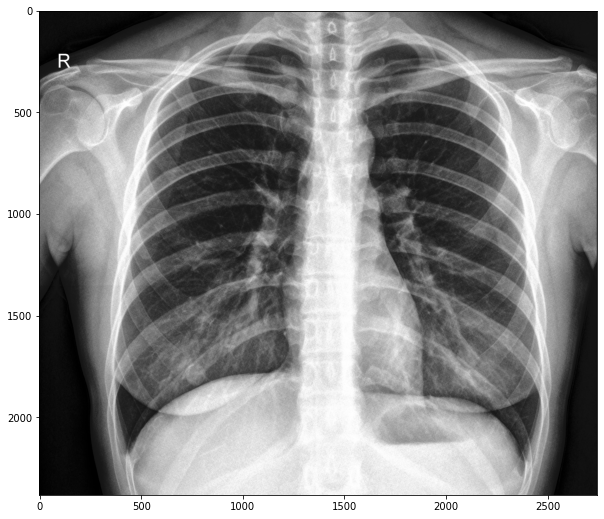

In [48]:
# Just checking a sample image
plt.figure(figsize= (10, 10))
img = io.imread("../input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Normal/02.jpeg")
plt.imshow(img)
plt.show()

In [49]:
# Implementing ImageDataGenerator to perform image augmentation
traingenerator = ImageDataGenerator(rescale= 1./255,horizontal_flip=True,vertical_flip=True ,width_shift_range=0.2,height_shift_range=0.2, zoom_range=0.2)
valgenerator = ImageDataGenerator(rescale= 1./255)
testgenerator = ImageDataGenerator(rescale= 1./255)

In [50]:
# flow_from_directory to get train, validation, test iterators
train_itr = traingenerator.flow_from_directory("../input/lungs-disease-dataset-4-types/Lung Disease Dataset/train", target_size = (224, 224), batch_size=64,
    class_mode="categorical",shuffle=True,seed=42)
validation_itr = valgenerator.flow_from_directory("../input/lungs-disease-dataset-4-types/Lung Disease Dataset/val", target_size = (224, 224),batch_size=64,
    class_mode="categorical",shuffle=True,seed=42)
test_itr = testgenerator.flow_from_directory("../input/lungs-disease-dataset-4-types/Lung Disease Dataset/test", target_size = (224, 224),batch_size=1,
    class_mode="categorical",shuffle=False)

Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


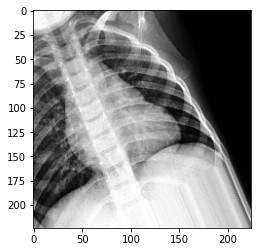

In [51]:
# Checking a sample picture after image augmentation
plt.figure()
plt.imshow(next(validation_itr)[0][0])
plt.show()

In [52]:
# Defining a network architecture

INPUT_SHAPE = (224, 224, 3)
input_layer = keras.layers.Input(shape=INPUT_SHAPE)

# 1st Convolutional Layer
conv1 = Conv2D(256, kernel_size=3, activation="relu",padding="same",kernel_initializer='he_normal',bias_initializer='zeros')(input_layer)
max_pool1 = MaxPooling2D(2)(conv1)
norm1 = BatchNormalization(axis= -1)(max_pool1)
drop1 = Dropout(0.1)(norm1)

# 2nd Convolutional Layer
conv2 = Conv2D(128, kernel_size=3, activation="relu",padding="same",kernel_initializer='he_normal',bias_initializer='zeros')(drop1)
max_pool2 = MaxPooling2D(2)(conv2)
norm2 = BatchNormalization(axis= -1)(max_pool2)
drop2 = Dropout(0.1)(norm2)

# 3rd Convolutional Layer
conv3 = Conv2D(64, kernel_size=3, activation="relu",padding="same",kernel_initializer='he_normal',bias_initializer='zeros')(drop2)
max_pool3 = MaxPooling2D(2)(conv3)
norm3 = BatchNormalization(axis= -1)(max_pool3)
drop3 = Dropout(0.1)(norm3)

# 4th Convolutional Layer
conv4 = Conv2D(32, kernel_size=3, activation="relu",padding="same",kernel_initializer='he_normal',bias_initializer='zeros')(drop3)
max_pool4 = MaxPooling2D(2)(conv4)
norm4 = BatchNormalization(axis= -1)(max_pool4)
drop4 = Dropout(0.1)(norm4)

# Flattening Layer
flat_output = Flatten()(drop4)

# 1st hidden fully connected Layer
hid_layer1 = Dense(512, activation="relu",kernel_initializer='he_normal',bias_initializer='zeros')(flat_output)
norm5 = BatchNormalization(axis= -1)(hid_layer1)
drop5 = Dropout(0.1)(norm5)

# Output Layer
output = Dense(5, activation="softmax")(drop5)

# Implementing ADAM Optimizer and Cross Entropy Loss 
cnn_model = keras.Model(inputs=input_layer, outputs=output)

cnn_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

# Printing the summary of our network architecture
print(cnn_model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 256)     0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 112, 112, 256)     1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0   

In [53]:
#Defining a callback for Saving the best model when the validation loss is the least 
checkpoint_filepath = 'my_best_model_ADAM.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_loss',
    mode='min', save_best_only=True,verbose = 1)

#Defining a callback for the Early Stopping with patience of 10 epochs
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=True)

#Defining a callback for Learning Rate change with factor of 0.5 if validation loss plateaus for 5 epochs
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5)#, min_lr=0.001)

#Training the Model
trained_model = cnn_model.fit(train_itr,epochs=30,steps_per_epoch=len(train_itr),validation_data=validation_itr,validation_steps=len(validation_itr),callbacks=[callback,reduce_lr,model_checkpoint_callback])

Epoch 1/30
95/95 [==============================] - 164s 2s/step - loss: 1.0013 - accuracy: 0.6440 - val_loss: 4.6748 - val_accuracy: 0.3522

Epoch 00001: val_loss improved from inf to 4.67483, saving model to my_best_model_ADAM.hdf5
Epoch 2/30
95/95 [==============================] - 160s 2s/step - loss: 0.6601 - accuracy: 0.7301 - val_loss: 2.3405 - val_accuracy: 0.3869

Epoch 00002: val_loss improved from 4.67483 to 2.34051, saving model to my_best_model_ADAM.hdf5
Epoch 3/30
95/95 [==============================] - 161s 2s/step - loss: 0.6175 - accuracy: 0.7415 - val_loss: 1.8388 - val_accuracy: 0.4415

Epoch 00003: val_loss improved from 2.34051 to 1.83881, saving model to my_best_model_ADAM.hdf5
Epoch 4/30
95/95 [==============================] - 159s 2s/step - loss: 0.5673 - accuracy: 0.7651 - val_loss: 1.4079 - val_accuracy: 0.5575

Epoch 00004: val_loss improved from 1.83881 to 1.40795, saving model to my_best_model_ADAM.hdf5
Epoch 5/30
95/95 [==============================] - 

In [54]:
# Saving the best model
my_model = keras.models.load_model(checkpoint_filepath)

In [55]:
# Plot Loss Function to plot learning curves
def plot_loss_curve(trained_model):

    train_loss = trained_model.history['loss']
    validation_loss = trained_model.history['val_loss']

    train_accuracy = trained_model.history['accuracy']
    validation_accuracy = trained_model.history['val_accuracy']

    epochs = range(len(trained_model.history['loss']))

    # plotting loss
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.title('Loss')
    plt.legend()

    # Plotting accuracy
    plt.figure()
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.title('Accuracy')
    plt.legend()

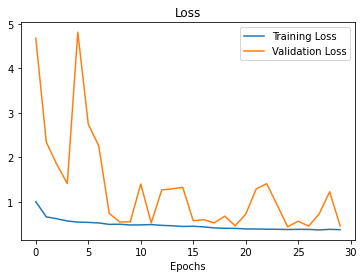

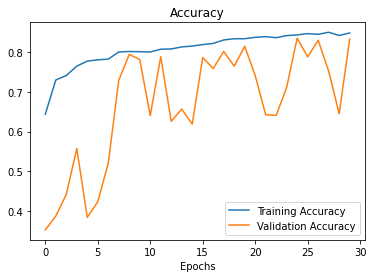

In [56]:
#Plotting the learning curves for the trained model
plot_loss_curve(trained_model)

In [57]:
# Getting predicted values and true values of test data
preds = []
y_true = []
for idx in tqdm.tqdm(range(0,len(test_itr))):
    prediction = my_model.predict(test_itr[idx][0])
    preds.extend(np.argmax(prediction,axis=1).tolist())
    y_true.append(np.argmax(test_itr[idx][1],axis=1).tolist()[0])

100%|██████████| 2025/2025 [02:12<00:00, 15.26it/s]


In [58]:
#Finding Accuracy
np.sum(np.array(y_true) == np.array(preds))/len(y_true)

0.8454320987654321

In [59]:
#Getting Classification Report and Confusion Matrix
print(metrics.classification_report(y_true=y_true,y_pred=preds))
print(confusion_matrix(y_true=y_true,y_pred=preds))

              precision    recall  f1-score   support

           0       0.70      0.82      0.75       403
           1       0.94      0.93      0.93       407
           2       0.89      0.90      0.89       404
           3       0.96      0.97      0.96       408
           4       0.75      0.61      0.67       403

    accuracy                           0.85      2025
   macro avg       0.85      0.84      0.84      2025
weighted avg       0.85      0.85      0.84      2025

[[330   1  13   1  58]
 [  7 379   3  14   4]
 [ 16   7 362   0  19]
 [  0  13   0 395   0]
 [120   5  31   1 246]]


# 